In [1]:
import torch
from torch import nn
import numpy as np
from mapsgan import Trajectories
import sys
%load_ext autoreload
%autoreload 2

In [2]:
td = Trajectories('/mnt/Clouds/MapsGAN/data/eth/test')

## Trajectory Toy Example

In [3]:
class ToyGenerator(nn.Module):
    
    def __init__(self, input_dim = 32, hidden_dim = 20, batch_size = 32):
        super().__init__()
        self.batch_size = batch_size
        self.hidden_dim = hidden_dim
        self.input_dim = input_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim)
        self.linear = nn.Sequential(nn.Linear(hidden_dim, 20*2),
                                    nn.ReLU())
        
    def init_hidden(self):
        return torch.zeros(1, self.batch_size, self.hidden_dim)
        
    def forward(self, z):
        _, (x, _) = self.lstm(z)
        x = self.linear(x)
        return x.view(self.hidden_dim, self.batch_size, 2)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_dim=2, mlp_dim=16, hidden_dim=64, num_layers=1):
        super(Discriminator, self).__init__()
        self.input_dim = input_dim
        self.mlp_dim = mlp_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.mlp_spatial_lstm = nn.Sequential(#nn.Linear(input_dim, mlp_dim),
                                              #nn.ReLU(),
                                              nn.LSTM(#mlp_dim,
                                                      input_dim,
                                                      hidden_dim,
                                                      num_layers))
        self.mlp_bool = nn.Sequential(nn.Linear(hidden_dim, 20),
                                      nn.Sigmoid())
        
    def forward(self, input_seq):
        _, (hidden, _) = self.mlp_spatial_lstm(input_seq)
        return self.mlp_bool(hidden.squeeze()).view(20, 32, 1)

In [5]:
TGen = ToyGenerator()
z = torch.randn(32, 32, 32)
TGen(z).shape

torch.Size([20, 32, 2])

In [6]:
TGen = ToyGenerator()
D = Discriminator()
ganloss_G = nn.BCELoss()
l1loss_G = nn.L1Loss()
lambda_G = 2
ganloss_D = nn.BCELoss()
optimG = torch.optim.Adam(TGen.parameters(), lr = 0.01)
optimD = torch.optim.Adam(D.parameters(), lr = 0.01)
epochs = 500
loss_G_l1_list = []
loss_G_gan_list = []
loss_D_list = []
for epoch in range(epochs):
    data_idx = np.random.randint(5) # len(td)) # get random sample
    labels = td[data_idx]['lossmask'] # get lossmask (20, 32)
    groundtruth = torch.cat((td[data_idx]['train'], td[data_idx]['groundtruth']), dim = 0)  # groundtruth (20, 32, 2)
    
    '''Train generator'''
    loss_G = 0
    optimG.zero_grad()
    z = torch.randn(32, 32, 32)
    prediction = TGen(z)
    out_D_pred = D(prediction)
    loss_G_l1 = l1loss_G(prediction[:,  0:td.peds_per_seq[data_idx]], groundtruth[:,  0:td.peds_per_seq[data_idx]]) # l1loss
    loss_G_l1_list.append(loss_G_l1)
    loss_G_gan = ganloss_G(out_D_pred.squeeze()[:, 0:td.peds_per_seq[data_idx]], labels[:, 0:td.peds_per_seq[data_idx]]) # ganloss
    loss_G_gan_list.append(loss_G_gan)
    loss_G = lambda_G*loss_G_l1 + loss_G_gan
    loss_G.backward(retain_graph=True)
    optimG.step()

    '''Train discriminator'''
    optimD.zero_grad()
    loss_D = 0
    out_D_real = D(groundtruth)
    out_D_fake = D(prediction)
    loss_D += ganloss_D(out_D_real.squeeze()[:, 0:td.peds_per_seq[data_idx]], labels[:, 0:td.peds_per_seq[data_idx]]) # on real
    loss_D += ganloss_D(out_D_fake.squeeze()[:, 0:td.peds_per_seq[data_idx]], ((labels-1)*(-1))[:, 0:td.peds_per_seq[data_idx]]) # on fake
    loss_D_list.append(loss_D)
    loss_D.backward(retain_graph=True)
    optimD.step()

    print("epoch: %d, loss_G_total: %1.3f, loss_G_l1: %1.3f, loss_G_gan: %1.3f, loss_D: %1.3f"%(epoch+1, loss_G, loss_G_l1, loss_G_gan, loss_D))  

epoch: 1, loss_G_total: 15.258, loss_G_l1: 7.285, loss_G_gan: 0.688, loss_D: 1.386
epoch: 2, loss_G_total: 16.645, loss_G_l1: 7.975, loss_G_gan: 0.694, loss_D: 1.370
epoch: 3, loss_G_total: 16.623, loss_G_l1: 7.960, loss_G_gan: 0.703, loss_D: 1.353
epoch: 4, loss_G_total: 16.574, loss_G_l1: 7.930, loss_G_gan: 0.715, loss_D: 1.337
epoch: 5, loss_G_total: 15.776, loss_G_l1: 7.518, loss_G_gan: 0.740, loss_D: 1.322
epoch: 6, loss_G_total: 15.204, loss_G_l1: 7.224, loss_G_gan: 0.755, loss_D: 1.314
epoch: 7, loss_G_total: 16.558, loss_G_l1: 7.902, loss_G_gan: 0.754, loss_D: 1.307
epoch: 8, loss_G_total: 15.167, loss_G_l1: 7.181, loss_G_gan: 0.806, loss_D: 1.285
epoch: 9, loss_G_total: 16.551, loss_G_l1: 7.845, loss_G_gan: 0.862, loss_D: 1.256
epoch: 10, loss_G_total: 16.577, loss_G_l1: 7.793, loss_G_gan: 0.992, loss_D: 1.129
epoch: 11, loss_G_total: 15.306, loss_G_l1: 7.016, loss_G_gan: 1.274, loss_D: 0.962
epoch: 12, loss_G_total: 16.701, loss_G_l1: 7.622, loss_G_gan: 1.456, loss_D: 0.879
e

epoch: 101, loss_G_total: 8.546, loss_G_l1: 2.282, loss_G_gan: 3.983, loss_D: 0.528
epoch: 102, loss_G_total: 8.522, loss_G_l1: 2.254, loss_G_gan: 4.014, loss_D: 0.524
epoch: 103, loss_G_total: 7.746, loss_G_l1: 1.863, loss_G_gan: 4.019, loss_D: 0.509
epoch: 104, loss_G_total: 5.657, loss_G_l1: 0.872, loss_G_gan: 3.914, loss_D: 0.519
epoch: 105, loss_G_total: 5.713, loss_G_l1: 0.907, loss_G_gan: 3.900, loss_D: 0.518
epoch: 106, loss_G_total: 5.665, loss_G_l1: 0.895, loss_G_gan: 3.875, loss_D: 0.516
epoch: 107, loss_G_total: 5.611, loss_G_l1: 0.882, loss_G_gan: 3.846, loss_D: 0.515
epoch: 108, loss_G_total: 5.545, loss_G_l1: 0.862, loss_G_gan: 3.821, loss_D: 0.515
epoch: 109, loss_G_total: 7.517, loss_G_l1: 1.799, loss_G_gan: 3.920, loss_D: 0.507
epoch: 110, loss_G_total: 8.297, loss_G_l1: 2.177, loss_G_gan: 3.944, loss_D: 0.516
epoch: 111, loss_G_total: 5.528, loss_G_l1: 0.837, loss_G_gan: 3.854, loss_D: 0.513
epoch: 112, loss_G_total: 7.608, loss_G_l1: 1.789, loss_G_gan: 4.031, loss_D

epoch: 201, loss_G_total: 6.023, loss_G_l1: 0.741, loss_G_gan: 4.541, loss_D: 0.418
epoch: 202, loss_G_total: 9.401, loss_G_l1: 2.341, loss_G_gan: 4.720, loss_D: 0.414
epoch: 203, loss_G_total: 9.320, loss_G_l1: 2.321, loss_G_gan: 4.678, loss_D: 0.404
epoch: 204, loss_G_total: 6.029, loss_G_l1: 0.789, loss_G_gan: 4.451, loss_D: 0.419
epoch: 205, loss_G_total: 9.109, loss_G_l1: 2.273, loss_G_gan: 4.564, loss_D: 0.396
epoch: 206, loss_G_total: 9.088, loss_G_l1: 2.244, loss_G_gan: 4.600, loss_D: 0.390
epoch: 207, loss_G_total: 9.067, loss_G_l1: 2.205, loss_G_gan: 4.656, loss_D: 0.384
epoch: 208, loss_G_total: 6.207, loss_G_l1: 0.852, loss_G_gan: 4.502, loss_D: 0.401
epoch: 209, loss_G_total: 6.074, loss_G_l1: 0.863, loss_G_gan: 4.348, loss_D: 0.424
epoch: 210, loss_G_total: 6.115, loss_G_l1: 0.867, loss_G_gan: 4.382, loss_D: 0.421
epoch: 211, loss_G_total: 6.176, loss_G_l1: 0.857, loss_G_gan: 4.462, loss_D: 0.415
epoch: 212, loss_G_total: 8.227, loss_G_l1: 1.769, loss_G_gan: 4.689, loss_D

epoch: 299, loss_G_total: 6.846, loss_G_l1: 0.982, loss_G_gan: 4.883, loss_D: 0.418
epoch: 300, loss_G_total: 6.875, loss_G_l1: 0.999, loss_G_gan: 4.878, loss_D: 0.414
epoch: 301, loss_G_total: 6.841, loss_G_l1: 0.990, loss_G_gan: 4.860, loss_D: 0.412
epoch: 302, loss_G_total: 6.773, loss_G_l1: 0.968, loss_G_gan: 4.838, loss_D: 0.411
epoch: 303, loss_G_total: 6.681, loss_G_l1: 0.930, loss_G_gan: 4.821, loss_D: 0.410
epoch: 304, loss_G_total: 6.604, loss_G_l1: 0.893, loss_G_gan: 4.817, loss_D: 0.410
epoch: 305, loss_G_total: 6.538, loss_G_l1: 0.855, loss_G_gan: 4.827, loss_D: 0.409
epoch: 306, loss_G_total: 6.479, loss_G_l1: 0.815, loss_G_gan: 4.849, loss_D: 0.408
epoch: 307, loss_G_total: 6.437, loss_G_l1: 0.780, loss_G_gan: 4.876, loss_D: 0.407
epoch: 308, loss_G_total: 9.788, loss_G_l1: 2.374, loss_G_gan: 5.039, loss_D: 0.351
epoch: 309, loss_G_total: 6.425, loss_G_l1: 0.734, loss_G_gan: 4.957, loss_D: 0.407
epoch: 310, loss_G_total: 10.046, loss_G_l1: 2.452, loss_G_gan: 5.142, loss_

epoch: 398, loss_G_total: 9.558, loss_G_l1: 2.052, loss_G_gan: 5.454, loss_D: 0.305
epoch: 399, loss_G_total: 10.262, loss_G_l1: 2.382, loss_G_gan: 5.497, loss_D: 0.310
epoch: 400, loss_G_total: 6.840, loss_G_l1: 0.746, loss_G_gan: 5.348, loss_D: 0.418
epoch: 401, loss_G_total: 9.375, loss_G_l1: 1.914, loss_G_gan: 5.547, loss_D: 0.302
epoch: 402, loss_G_total: 10.035, loss_G_l1: 2.236, loss_G_gan: 5.564, loss_D: 0.305
epoch: 403, loss_G_total: 7.056, loss_G_l1: 0.838, loss_G_gan: 5.380, loss_D: 0.415
epoch: 404, loss_G_total: 7.077, loss_G_l1: 0.857, loss_G_gan: 5.364, loss_D: 0.406
epoch: 405, loss_G_total: 6.963, loss_G_l1: 0.867, loss_G_gan: 5.229, loss_D: 0.370
epoch: 406, loss_G_total: 9.425, loss_G_l1: 2.127, loss_G_gan: 5.171, loss_D: 0.427
epoch: 407, loss_G_total: 8.953, loss_G_l1: 1.731, loss_G_gan: 5.491, loss_D: 0.315
epoch: 408, loss_G_total: 9.915, loss_G_l1: 2.105, loss_G_gan: 5.705, loss_D: 0.308
epoch: 409, loss_G_total: 7.538, loss_G_l1: 0.990, loss_G_gan: 5.559, loss

epoch: 497, loss_G_total: 6.525, loss_G_l1: 0.771, loss_G_gan: 4.982, loss_D: 0.400
epoch: 498, loss_G_total: 9.640, loss_G_l1: 2.274, loss_G_gan: 5.091, loss_D: 0.366
epoch: 499, loss_G_total: 8.802, loss_G_l1: 1.847, loss_G_gan: 5.108, loss_D: 0.361
epoch: 500, loss_G_total: 8.751, loss_G_l1: 1.811, loss_G_gan: 5.129, loss_D: 0.358


In [7]:
z = torch.randn(32, 32, 32)
predicted = TGen(z)

In [8]:
predicted[0, 0:td.peds_per_seq[data_idx]], groundtruth[0,0:td.peds_per_seq[data_idx]]

(tensor([[7.2274, 7.6265],
         [8.3665, 8.2747]], grad_fn=<SliceBackward>),
 tensor([[10.3100,  5.9700],
         [12.4900,  6.6000]]))

In [9]:
import matplotlib.pyplot as plt

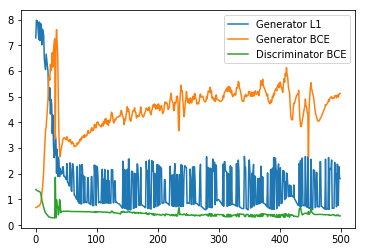

In [10]:
plt.plot(loss_G_l1_list, label = 'Generator L1')
plt.plot(loss_G_gan_list, label = 'Generator BCE')
plt.plot(loss_D_list, label = 'Discriminator BCE')
plt.legend()